In [2]:
#@title BƯỚC 1: CÀI ĐẶT VÀ NHẬP THƯ VIỆN
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import gc

# Thư viện Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

# Thư viện TensorFlow và Keras
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

2025-10-26 09:51:16.735131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761472277.110809      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761472277.239393      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [4]:
# Dữ liệu đầu vào
CSV_FILE_PATH = '/kaggle/input/doanml/part-00000-41f8a7f7-767e-4f2b-9ac9-b59ff9174cdb-c000.csv' # File CSV gốc từ dataset Kaggle
IMAGE_FOLDER_PATH = '/kaggle/input/doanml/socal_pics/socal_pics' # Thư mục ảnh gốc

# Dữ liệu đầu ra (nơi lưu mô hình)
BASE_OUTPUT_PATH = '/kaggle/working/'

# --- Dữ liệu ---
NUM_SAMPLES_TO_TEST = None 

# --- Cấu hình VGG16 (Tối ưu) ---
TARGET_SIZE = (224, 224)
PREPROCESS_FUNC = vgg_preprocess
MODEL_NAME = 'VGG16_Optimized'

# === CÁC SIÊU THAM SỐ TỐI ƯU ===
BEST_UNFREEZE_LAYERS = 7
BEST_DROPOUT_RATE = 0.4
BEST_LEARNING_RATE = 1e-4

# --- Cấu hình lưu trữ ---
CHECKPOINT_PATH = BASE_OUTPUT_PATH + f"{MODEL_NAME}_best_checkpoint.keras"
print(f"Đã chọn mô hình: {MODEL_NAME}")
print(f"File CSV sẽ được đọc từ: {CSV_FILE_PATH}")
print(f"File mô hình sẽ được lưu tại: {CHECKPOINT_PATH}")

Đã chọn mô hình: VGG16_Optimized
File CSV sẽ được đọc từ: /kaggle/input/doanml/part-00000-41f8a7f7-767e-4f2b-9ac9-b59ff9174cdb-c000.csv
File mô hình sẽ được lưu tại: /kaggle/working/VGG16_Optimized_best_checkpoint.keras


In [5]:
#@title BƯỚC 3: TẢI VÀ CHUẨN BỊ DỮ LIỆU
print("--- Bắt đầu Bước 3: Tải và Chuẩn bị Dữ liệu ---")
try:
    df_full = pd.read_csv(CSV_FILE_PATH)
    print(f"Tải thành công {len(df_full)} dòng dữ liệu.")
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file tại '{CSV_FILE_PATH}'.")
    print("Vui lòng kiểm tra lại: Bạn đã 'Add Data' dataset 'house-prices-and-images-socal' chưa?")
    exit()

if NUM_SAMPLES_TO_TEST is not None and NUM_SAMPLES_TO_TEST < len(df_full):
    print(f"Đang giới hạn dữ liệu xuống còn {NUM_SAMPLES_TO_TEST} mẫu.")
    df = df_full.sample(n=NUM_SAMPLES_TO_TEST, random_state=42).reset_index(drop=True)
else:
    df = df_full.copy()

df.dropna(subset=['price', 'image_id', 'citi'], inplace=True)
df['price_scaled'] = df['price'] / 1_000_000.0
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Đã chia dữ liệu: {len(train_df)} mẫu huấn luyện, {len(val_df)} mẫu kiểm định.")

# --- Định nghĩa Data Generator ---
class HousePriceGenerator(Sequence):
    def __init__(self, df, image_folder, batch_size, target_size, preprocess_func, shuffle=True):
        self.df = df
        self.image_folder = image_folder
        self.batch_size = batch_size
        self.target_size = target_size
        self.preprocess_func = preprocess_func
        self.shuffle = shuffle
        self.indexes = self.df.index.tolist()
        self.on_epoch_end()
    def __len__(self): return math.ceil(len(self.df) / self.batch_size)
    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.indexes)
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.loc[batch_indexes]
        X = self._generate_X(batch_df)
        y = batch_df['price_scaled'].values
        return X, y
    def _generate_X(self, batch_df):
        X = np.empty((len(batch_df), *self.target_size, 3))
        for i, (_, row) in enumerate(batch_df.iterrows()):
            # Ảnh trong Kaggle dataset được đặt tên là {image_id}.jpg
            img_path = f"{self.image_folder}{row['image_id']}.jpg"
            try:
                img = image.load_img(img_path, target_size=self.target_size)
                img_array = image.img_to_array(img)
                X[i,] = self.preprocess_func(img_array)
            except FileNotFoundError:
                X[i,] = np.zeros((*self.target_size, 3))
        return X

BATCH_SIZE = 32
train_generator = HousePriceGenerator(train_df, IMAGE_FOLDER_PATH, BATCH_SIZE, TARGET_SIZE, PREPROCESS_FUNC, shuffle=True)
val_generator = HousePriceGenerator(val_df, IMAGE_FOLDER_PATH, BATCH_SIZE, TARGET_SIZE, PREPROCESS_FUNC, shuffle=False)

--- Bắt đầu Bước 3: Tải và Chuẩn bị Dữ liệu ---
Tải thành công 12328 dòng dữ liệu.
Đã chia dữ liệu: 9862 mẫu huấn luyện, 2466 mẫu kiểm định.


In [6]:
#@title BƯỚC 4: HUẤN LUYỆN MÔ HÌNH VGG16 TỐI ƯU
print("\n--- Bắt đầu Bước 4: Huấn luyện mô hình VGG16 Tối ưu ---")

# Hàm tạo mô hình VGG16
def create_finetune_model(unfreeze_layers, dropout_rate, learning_rate):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*TARGET_SIZE, 3))
    for layer in base_model.layers[:-unfreeze_layers]:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D(name='feature_extractor_layer')(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='linear')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss='mean_squared_error')
    return model

# Xây dựng mô hình cuối cùng với các tham số tốt nhất
final_model = create_finetune_model(
    unfreeze_layers=BEST_UNFREEZE_LAYERS,
    dropout_rate=BEST_DROPOUT_RATE,
    learning_rate=BEST_LEARNING_RATE
)
print(f"Đã tạo mô hình với các tham số: rã đông={BEST_UNFREEZE_LAYERS}, dropout={BEST_DROPOUT_RATE}, lr={BEST_LEARNING_RATE}")

# Tạo callbacks
final_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(
    filepath=CHECKPOINT_PATH,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

print("\nBắt đầu huấn luyện với Early Stopping và Checkpointing...")
history = final_model.fit(train_generator,
                          validation_data=val_generator,
                          epochs=50, 
                          callbacks=[final_early_stopping, checkpoint_callback],
                          verbose=1)

print(f"Huấn luyện hoàn tất. Mô hình tốt nhất đã được lưu tại: {CHECKPOINT_PATH}")


--- Bắt đầu Bước 4: Huấn luyện mô hình VGG16 Tối ưu ---


I0000 00:00:1761472295.241164      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761472295.241863      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Đã tạo mô hình với các tham số: rã đông=7, dropout=0.4, lr=0.0001

Bắt đầu huấn luyện với Early Stopping và Checkpointing...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1761472301.587528      82 service.cc:148] XLA service 0x78b1b8002c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761472301.589164      82 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761472301.589186      82 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761472302.170405      82 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/309 ━━━━━━━━━━━━━━━━━━━━ 1:47:29 21s/step - loss: 1.4552

I0000 00:00:1761472318.681063      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.2401

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.15731, saving model to /kaggle/working/VGG16_Optimized_best_checkpoint.keras
309/309 ━━━━━━━━━━━━━━━━━━━━ 111s 292ms/step - loss: 0.2399 - val_loss: 0.1573
Epoch 2/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.1690
Epoch 2: val_loss did not improve from 0.15731
309/309 ━━━━━━━━━━━━━━━━━━━━ 83s 270ms/step - loss: 0.1690 - val_loss: 0.1592
Epoch 3/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.1702
Epoch 3: val_loss did not improve from 0.15731
309/309 ━━━━━━━━━━━━━━━━━━━━ 83s 270ms/step - loss: 0.1702 - val_loss: 0.1583
Epoch 4/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.1640
Epoch 4: val_loss improved from 0.15731 to 0.15579, saving model to /kaggle/working/VGG16_Optimized_best_checkpoint.keras
309/309 ━━━━━━━━━━━━━━━━━━━━ 84s 273ms/step - loss: 0.1640 - val_loss: 0.1558
Epoch 5/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.1657
Epoch 5: val_loss did not improve from 0.15579
309/309 ━━━━━━━━━━━━━━━━━━━━ 


--- Vẽ biểu đồ Validation Loss từ quá trình huấn luyện cuối cùng ---
Đã lưu biểu đồ vào: /kaggle/working/VGG16_Optimized_val_loss_plot.png


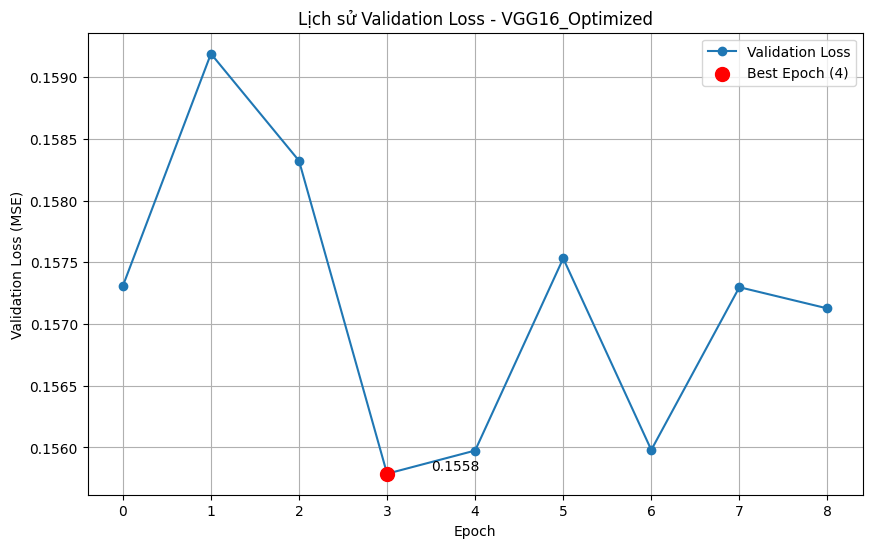

In [15]:

print("\n--- Vẽ biểu đồ Validation Loss từ quá trình huấn luyện cuối cùng ---")

if 'history' in locals() and history is not None:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['val_loss'], marker='o', linestyle='-', label='Validation Loss')
    
    # Tìm epoch có val_loss thấp nhất
    best_epoch = np.argmin(history.history['val_loss'])
    best_val_loss = history.history['val_loss'][best_epoch]
    
    # Đánh dấu điểm tốt nhất trên biểu đồ
    plt.scatter(best_epoch, best_val_loss, color='red', s=100, label=f'Best Epoch ({best_epoch+1})', zorder=5)
    plt.text(best_epoch + 0.5, best_val_loss, f'{best_val_loss:.4f}', verticalalignment='bottom')
    
    plt.title(f'Lịch sử Validation Loss - {MODEL_NAME}')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss (MSE)')
    plt.legend()
    plt.grid(True)
    
    # Lưu biểu đồ
    plot_save_path = BASE_OUTPUT_PATH + f'{MODEL_NAME}_val_loss_plot.png'
    plt.savefig(plot_save_path)
    print(f"Đã lưu biểu đồ vào: {plot_save_path}")
    
    # Hiển thị biểu đồ (nếu môi trường hỗ trợ)
    plt.show() 
else:
    print("Không tìm thấy biến 'history'. Hãy đảm bảo bạn đã chạy Bước 4 (Huấn luyện).")

In [ ]:
#@title BƯỚC 5: TRÍCH XUẤT ĐẶC TRƯNG TỪ MÔ HÌNH TỐT NHẤT
print("\n--- Bắt đầu Bước 5: Trích xuất đặc trưng ---")

# Tải lại mô hình tốt nhất từ file checkpoint
print("Tải lại mô hình tốt nhất từ checkpoint...")
best_model = tf.keras.models.load_model(CHECKPOINT_PATH)
feature_extractor_ft = Model(inputs=best_model.input, outputs=best_model.get_layer('feature_extractor_layer').output)

all_image_paths = [f"{IMAGE_FOLDER_PATH}{img_id}.jpg" for img_id in df['image_id']]
image_features_list = []
for path in tqdm(all_image_paths, desc="Trích xuất đặc trưng VGG16"):
    try:
        img = image.load_img(path, target_size=TARGET_SIZE)
        img_array = np.expand_dims(image.img_to_array(img), axis=0)
        img_array = PREPROCESS_FUNC(img_array)
        features = feature_extractor_ft.predict(img_array, verbose=0)
        image_features_list.append(features.flatten())
    except FileNotFoundError:
        image_features_list.append(np.zeros(512)) # VGG16 output 512
image_features_matrix = np.array(image_features_list)
print(f"Ma trận đặc trưng ảnh: {image_features_matrix.shape}")

# Tạo đặc trưng bảng (với phiên bản cải tiến)
print("Tạo đặc trưng bảng (phiên bản cải tiến)...")
features_tabular = ['bed', 'bath', 'sqft', 'price']
df_tabular_engineered = df[features_tabular].copy()
df_tabular_engineered.fillna(df_tabular_engineered.mean(), inplace=True)
df_tabular_engineered['price'] = np.log1p(df_tabular_engineered['price'])
df_tabular_engineered['sqft'] = np.log1p(df_tabular_engineered['sqft'])
scaler_tabular = MinMaxScaler()
tabular_features_matrix = scaler_tabular.fit_transform(df_tabular_engineered)
feature_weights = np.array([0.8, 0.8, 1.0, 1.5])
tabular_features_matrix = tabular_features_matrix * feature_weights
print(f"Ma trận đặc trưng bảng (cải tiến): {tabular_features_matrix.shape}")


--- Bắt đầu Bước 5: Trích xuất đặc trưng ---
Tải lại mô hình tốt nhất từ checkpoint...


Trích xuất đặc trưng VGG16:   0%|          | 0/12328 [00:00<?, ?it/s]

Ma trận đặc trưng ảnh: (12328, 512)
Tạo đặc trưng bảng (phiên bản cải tiến)...
Ma trận đặc trưng bảng (cải tiến): (12328, 4)


In [ ]:
#@title BƯỚC 6: TỐI ƯU HÓA TRỌNG SỐ `weight_image` VÀ ĐÁNH GIÁ
print("\n--- Bắt đầu Bước 6: Tối ưu `weight_image` và Đánh giá ---")

# --- Định nghĩa các hàm gợi ý và đánh giá (với F1, Recall) ---
def get_ground_truth(house_id, df_source, price_tolerance=0.20):
    try:
        original_house = df_source[df_source['image_id'] == house_id].iloc[0]
    except IndexError: return set()
    original_price = original_house['price']
    lower_bound, upper_bound = original_price * (1 - price_tolerance), original_price * (1 + price_tolerance)
    bed_lower_bound, bed_upper_bound = original_house['bed'] - 1, original_house['bed'] + 1
    ground_truth_df = df_source[
        (df_source['citi'] == original_house['citi']) &
        (df_source['bed'] >= bed_lower_bound) & (df_source['bed'] <= bed_upper_bound) &
        (df_source['price'] >= lower_bound) & (df_source['price'] <= upper_bound) &
        (df_source['image_id'] != house_id)
    ]
    return set(ground_truth_df['image_id'])
def get_recommendations(image_id, df_source, sim_matrix):
    try: idx = df_source.index.get_loc(df_source[df_source['image_id'] == image_id].index[0])
    except (IndexError, KeyError): return pd.DataFrame()
    sim_scores = list(enumerate(sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]
    house_indices = [i[0] for i in sim_scores]
    return df_source.iloc[house_indices]
def precision_at_k(recommendations, ground_truth, k=5):
    if not ground_truth or recommendations.empty: return 0.0
    rec_ids = set(recommendations.head(k)['image_id'])
    return len(rec_ids.intersection(ground_truth)) / k
def recall_at_k(recommendations, ground_truth, k=5):
    if not ground_truth or recommendations.empty: return 0.0
    rec_ids = set(recommendations.head(k)['image_id'])
    return len(rec_ids.intersection(ground_truth)) / len(ground_truth)
def f1_score(precision, recall):
    if (precision + recall) == 0: return 0.0
    return 2 * (precision * recall) / (precision + recall)

# --- Tính toán cho Mô hình Bảng ---
cosine_sim_tabular = cosine_similarity(tabular_features_matrix)
precisions_tabular, recalls_tabular, f1s_tabular = [], [], []
for house_id in tqdm(df['image_id'], desc="Đánh giá Mô hình Bảng"):
    ground_truth = get_ground_truth(house_id, df)
    if not ground_truth: continue
    recs_tabular = get_recommendations(house_id, df, cosine_sim_tabular)
    p_tab = precision_at_k(recs_tabular, ground_truth)
    r_tab = recall_at_k(recs_tabular, ground_truth)
    f1s_tabular.append(f1_score(p_tab, r_tab))
    precisions_tabular.append(p_tab)
    recalls_tabular.append(r_tab)
p_tabular = np.mean(precisions_tabular) if precisions_tabular else 0.0
r_tabular = np.mean(recalls_tabular) if recalls_tabular else 0.0
f1_tabular = np.mean(f1s_tabular) if f1s_tabular else 0.0

# --- Grid Search tìm `weight_image` tốt nhất ---
scaler_image = MinMaxScaler()
image_features_scaled = scaler_image.fit_transform(image_features_matrix)
best_weight = 0.0 # Khởi tạo best_weight
best_f1 = 0.0     # Khởi tạo best_f1
weight_results = [] 
# ===============================================
for weight_image in tqdm(np.linspace(0, 1, 11), desc="Tìm kiếm `weight_image` tốt nhất"):
    hybrid_features = np.concatenate([
        tabular_features_matrix * (1 - weight_image),
        image_features_scaled * weight_image
    ], axis=1)
    cosine_sim_hybrid = cosine_similarity(hybrid_features)
    precisions_hybrid, recalls_hybrid, f1s_hybrid = [], [], []
    for house_id in df['image_id']:
        ground_truth = get_ground_truth(house_id, df)
        if not ground_truth: continue
        recs_hybrid = get_recommendations(house_id, df, cosine_sim_hybrid)
        p_hyb = precision_at_k(recs_hybrid, ground_truth)
        r_hyb = recall_at_k(recs_hybrid, ground_truth)
        f1s_hybrid.append(f1_score(p_hyb, r_hyb))
        precisions_hybrid.append(p_hyb)
        recalls_hybrid.append(r_hyb)
    p_hybrid = np.mean(precisions_hybrid) if precisions_hybrid else 0.0
    r_hybrid = np.mean(recalls_hybrid) if recalls_hybrid else 0.0
    f1_hybrid = np.mean(f1s_hybrid) if f1s_hybrid else 0.0
    
    weight_results.append({'weight': f'{weight_image:.1f}', 'P@5': p_hybrid, 'R@5': r_hybrid, 'F1@5': f1_hybrid})
# ============================================
    
    if f1_hybrid > best_f1:
        best_f1 = f1_hybrid
        best_weight = weight_image



--- Bắt đầu Bước 6: Tối ưu `weight_image` và Đánh giá ---


Đánh giá Mô hình Bảng:   0%|          | 0/12328 [00:00<?, ?it/s]

Tìm kiếm `weight_image` tốt nhất:   0%|          | 0/11 [00:00<?, ?it/s]

In [14]:
#@title BƯỚC 7: KẾT QUẢ TỐI ƯU HÓA CUỐI CÙNG (Thêm Debugging)
print("\n=========================================================")
print(f"      KẾT QUẢ TỐI ƯU HÓA CUỐI CÙNG ({MODEL_NAME})")
print("=========================================================")

# In kết quả mô hình Bảng
print("--- Mô hình Chỉ dùng Dữ liệu Bảng ---")
print(f"  Precision@5: {p_tabular:.4f}")
print(f"  Recall@5: {r_tabular:.4f}")
print(f"  F1-score@5: {f1_tabular:.4f}")
print("---")

# In kết quả Grid Search
print("\n--- Kết quả thử nghiệm Trọng số Ảnh (`weight_image`) ---")
try:
    # Chỉ tạo DataFrame nếu list không rỗng VÀ là list
    if isinstance(weight_results, list) and weight_results:
        results_df = pd.DataFrame.from_records(weight_results)
        results_df.set_index('weight', inplace=True)
        print(results_df.to_string(float_format="%.4f"))
    elif isinstance(weight_results, pd.DataFrame): # Nếu nó đã là DataFrame rồi (trường hợp hiếm)
         results_df = weight_results
         if 'weight' in results_df.columns: results_df.set_index('weight', inplace=True)
         print(results_df.to_string(float_format="%.4f"))
    else:
        print("Không thể tạo DataFrame: weight_results rỗng hoặc có cấu trúc không đúng.")
except Exception as e:
    print(f"LỖI khi tạo DataFrame: {e}") # In ra lỗi cụ thể nếu có
    print("Kiểm tra lại cấu trúc của 'weight_results' dựa trên thông tin debug ở trên.")

print("---")

# In kết quả tốt nhất (Thêm kiểm tra để tránh lỗi nếu best_f1=0)
print(f"Trọng số ảnh (`weight_image`) tối ưu nhất (dựa trên F1-score): {best_weight:.1f}")
if best_f1 > 0:
    print(f"Mô hình Lai Tối ưu ({MODEL_NAME}) đạt F1-score@5: {best_f1:.4f}")
else:
    print(f"Mô hình Lai Tối ưu ({MODEL_NAME}) không đạt được F1-score > 0.")


if best_f1 > f1_tabular:
    print(f"\n✅ THÀNH CÔNG! Mô hình lai {MODEL_NAME} tối ưu (F1: {best_f1:.4f}) đã vượt qua mô hình bảng (F1: {f1_tabular:.4f}).")
else:
     # Kiểm tra xem F1 của mô hình bảng có > 0 không
     if f1_tabular > 0:
         print(f"\n⚠️ Mô hình lai {MODEL_NAME} (F1: {best_f1:.4f}) vẫn chưa vượt qua được mô hình bảng (F1: {f1_tabular:.4f}).")
     else:
         print(f"\n⚠️ Cả mô hình lai (F1: {best_f1:.4f}) và mô hình bảng (F1: {f1_tabular:.4f}) đều có F1-score thấp.")


      KẾT QUẢ TỐI ƯU HÓA CUỐI CÙNG (VGG16_Optimized)
--- Mô hình Chỉ dùng Dữ liệu Bảng ---
  Precision@5: 0.0443
  Recall@5: 0.0086
  F1-score@5: 0.0118
---

--- Kết quả thử nghiệm Trọng số Ảnh (`weight_image`) ---
          P@5    R@5   F1@5
weight                     
0.0    0.0443 0.0086 0.0118
0.1    0.0443 0.0086 0.0118
0.2    0.0443 0.0086 0.0118
0.3    0.0443 0.0086 0.0118
0.4    0.0443 0.0086 0.0118
0.5    0.0443 0.0086 0.0118
0.6    0.0443 0.0086 0.0118
0.7    0.0443 0.0086 0.0118
0.8    0.0443 0.0086 0.0118
0.9    0.0443 0.0086 0.0118
1.0    0.0000 0.0002 0.0001
---
Trọng số ảnh (`weight_image`) tối ưu nhất (dựa trên F1-score): 0.0
Mô hình Lai Tối ưu (VGG16_Optimized) đạt F1-score@5: 0.0118

⚠️ Mô hình lai VGG16_Optimized (F1: 0.0118) vẫn chưa vượt qua được mô hình bảng (F1: 0.0118).


--- GỢI Ý CHO NHÀ CÓ image_id = 1 ---

## Thông tin Nhà Gốc:
           street         citi  bed  bath  sqft   price
0  124 C Street W  Brawley, CA    3     2   713  228500

## Gợi ý từ Mô hình Chỉ dùng Dữ liệu Bảng:
      image_id                  street             citi  bed  bath  sqft  \
6842      8500  13667 Mayflower Street  Victorville, CA    6     4  3157   
542        631              3549 W K10    Lancaster, CA    4     2  1178   
6864      8526      14447 Laguna Court     Adelanto, CA    5     3  1921   
4505      5506    83588 Emerald Avenue        Indio, CA    4     2  1170   
4554      5565     40953 Acacia Avenue        Hemet, CA    5     3  1975   

       price  
6842  299000  
542   249000  
6864  260000  
4505  252000  
4554  279900  

## Gợi ý từ Mô hình Lai Tối ưu (VGG16, weight=0.0):
      image_id                  street             citi  bed  bath  sqft  \
6842      8500  13667 Mayflower Street  Victorville, CA    6     4  3157   
542        631              354

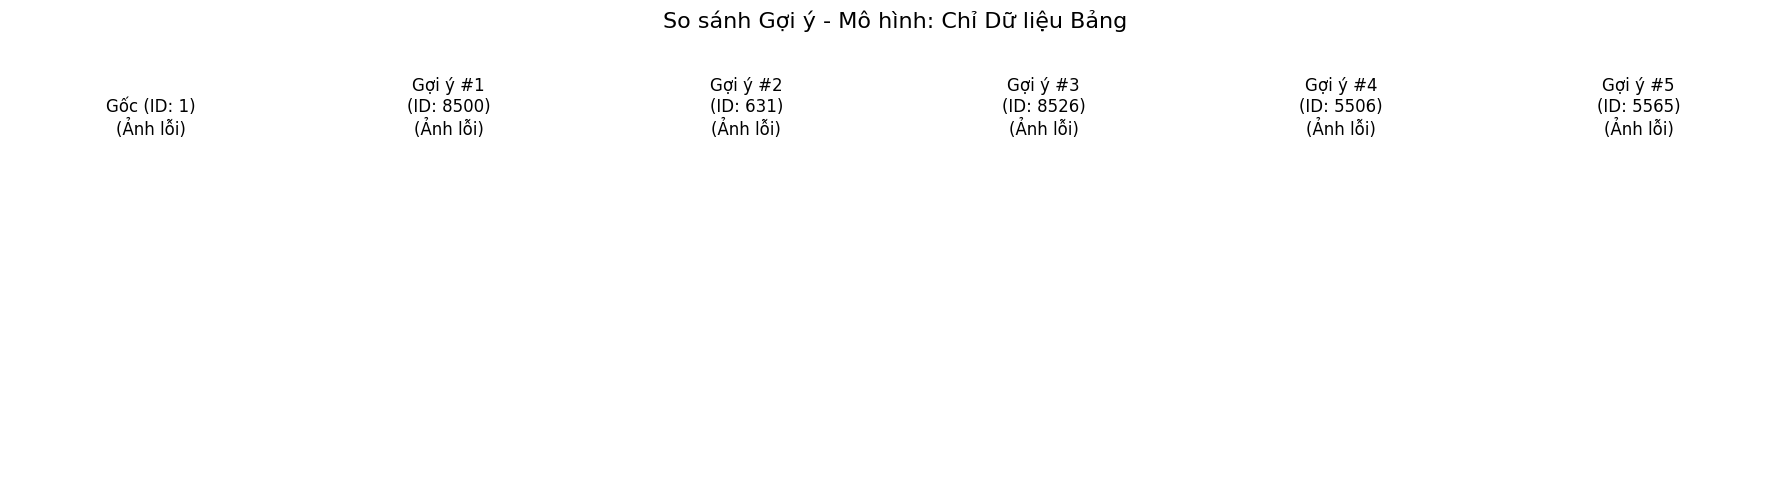

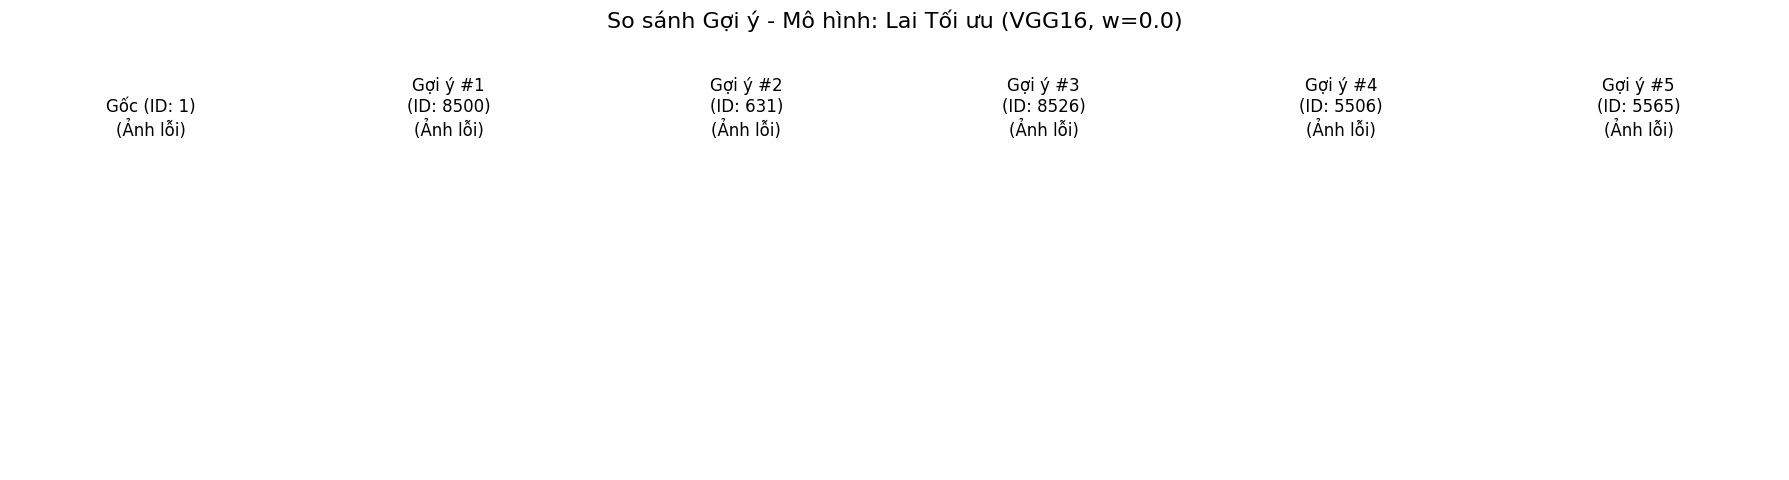

In [ ]:
#@title BƯỚC 8: HIỂN THỊ KẾT QUẢ GỢI Ý MẪU

# Chọn một image_id để xem gợi ý
target_image_id = 1

# Lấy thông tin nhà gốc
original_house = df[df['image_id'] == target_image_id]

# Lấy gợi ý từ mô hình Bảng
recs_tabular = get_recommendations(target_image_id, df, cosine_sim_tabular)

# Lấy gợi ý từ mô hình Lai (sử dụng trọng số tốt nhất đã tìm thấy)
# Tái tạo lại ma trận tương đồng lai với trọng số tốt nhất
best_hybrid_features = np.concatenate([
    tabular_features_matrix * (1 - best_weight),
    image_features_scaled * best_weight
], axis=1)
best_cosine_sim_hybrid = cosine_similarity(best_hybrid_features)
recs_hybrid = get_recommendations(target_image_id, df, best_cosine_sim_hybrid)

# --- Hiển thị kết quả ---
print(f"--- GỢI Ý CHO NHÀ CÓ image_id = {target_image_id} ---")

print("\n## Thông tin Nhà Gốc:")
print(original_house[['street', 'citi', 'bed', 'bath', 'sqft', 'price']])

print("\n## Gợi ý từ Mô hình Chỉ dùng Dữ liệu Bảng:")
if not recs_tabular.empty:
    print(recs_tabular[['image_id', 'street', 'citi', 'bed', 'bath', 'sqft', 'price']])
else:
    print("Không tìm thấy gợi ý.")

print(f"\n## Gợi ý từ Mô hình Lai Tối ưu (VGG16, weight={best_weight:.1f}):")
if not recs_hybrid.empty:
    print(recs_hybrid[['image_id', 'street', 'citi', 'bed', 'bath', 'sqft', 'price']])
else:
    print("Không tìm thấy gợi ý.")

# --- Hiển thị hình ảnh (Tùy chọn) ---
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def show_comparison_images(original_id, recs_df, model_name, image_folder, target_size):
    """Hiển thị ảnh gốc và các ảnh gợi ý."""
    if recs_df.empty:
        print(f"\nKhông có ảnh để hiển thị cho {model_name}.")
        return

    plt.figure(figsize=(18, 5))
    num_recs = len(recs_df)

    # Ảnh gốc
    try:
        plt.subplot(1, num_recs + 1, 1)
        original_img_path = f"{image_folder}{original_id}.jpg"
        plt.imshow(image.load_img(original_img_path, target_size=target_size))
        plt.title(f"Gốc (ID: {original_id})")
        plt.axis('off')
    except FileNotFoundError:
        plt.title(f"Gốc (ID: {original_id})\n(Ảnh lỗi)")
        plt.axis('off')

    # Ảnh gợi ý
    for i, row in enumerate(recs_df.itertuples()):
        plt.subplot(1, num_recs + 1, i + 2)
        try:
            rec_img_path = f"{image_folder}{row.image_id}.jpg"
            plt.imshow(image.load_img(rec_img_path, target_size=target_size))
            plt.title(f"Gợi ý #{i+1}\n(ID: {row.image_id})")
        except FileNotFoundError:
             plt.title(f"Gợi ý #{i+1}\n(ID: {row.image_id})\n(Ảnh lỗi)")
        plt.axis('off')

    plt.suptitle(f'So sánh Gợi ý - Mô hình: {model_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

# Hiển thị ảnh so sánh
print("\n--- So sánh Hình ảnh ---")
show_comparison_images(target_image_id, recs_tabular, "Chỉ Dữ liệu Bảng", IMAGE_FOLDER_PATH, TARGET_SIZE)
show_comparison_images(target_image_id, recs_hybrid, f"Lai Tối ưu (VGG16, w={best_weight:.1f})", IMAGE_FOLDER_PATH, TARGET_SIZE)